# VGG-16 재훈련
## VGG-16 Model
* University of Oxford - Visual Geometry Group
* 2014 ILSVRC 2nd Model
* ImageNet Large Scale Visual Recognition Challenge (ILSVRC)


In [1]:
import warnings
warnings.filterwarnings('ignore')

* Import TensorFlow

In [2]:
import tensorflow as tf

tf.__version__

'2.9.2'

# I. wget From Github
* 'dogs_and_cats_small.zip' 파일 다운로드

In [3]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip

--2022-11-12 08:00:44--  https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90618980 (86M) [application/zip]
Saving to: ‘dogs_and_cats_small.zip’

dogs_and_cats_small 100%[===================>]  86.42M   217MB/s    in 0.4s    

2022-11-12 08:00:45 (217 MB/s) - ‘dogs_and_cats_small.zip’ saved [90618980/90618980]



* 다운로드 결과 확인

In [4]:
!ls -l 

total 88500
-rw-r--r-- 1 root root 90618980 Nov 12 08:00 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Nov 10 14:30 sample_data


# II. Data Preprocessing

> ## 1) Unzip 'dogs_and_cats_small.zip'

In [5]:
!unzip -q /content/dogs_and_cats_small.zip

* 학습 데이터 확인

In [6]:
!ls -l

total 88512
-rw-r--r-- 1 root root 90618980 Nov 12 08:00 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Nov 10 14:30 sample_data
drwxr-xr-x 4 root root     4096 Nov 12 08:00 test
drwxr-xr-x 4 root root     4096 Nov 12 08:00 train
drwxr-xr-x 4 root root     4096 Nov 12 08:00 validation


> ## 2) Image_File Directory Setting

* train_dir
* valid_dir
* test_dir

In [7]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

# III. Data Preprocessing

> ## 1) ImageDataGenerator( ) & flow_from_directory( )

* Normalization
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_directory( )

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# With Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

# Without Augmentation 
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# IV. Import VGG-16 Model

> ## 1) conv_base

In [9]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

58889256/58889256 [==============================] - 1s 0us/step


# V. Keras CNN Modeling with VGG-16

> ## 1) Model Define

* 'conv_base' & 'Classification' Network
* Dropout Layer

In [10]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정
 * 이미 학습된 Weight 값을 Tuning
 * 매우 작은 Learnig Rate 지정
 * optimizers.Adam(lr = 0.000005)

In [12]:
from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 12분

In [13]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 25,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/25
100/100 [==============================] - 37s 236ms/step - loss: 0.7034 - accuracy: 0.5685 - val_loss: 0.5729 - val_accuracy: 0.6920
Epoch 2/25
100/100 [==============================] - 23s 230ms/step - loss: 0.5972 - accuracy: 0.6865 - val_loss: 0.3890 - val_accuracy: 0.8450
Epoch 3/25
100/100 [==============================] - 25s 247ms/step - loss: 0.4823 - accuracy: 0.7750 - val_loss: 0.3019 - val_accuracy: 0.8780
Epoch 4/25
100/100 [==============================] - 24s 236ms/step - loss: 0.3907 - accuracy: 0.8210 - val_loss: 0.2737 - val_accuracy: 0.8870
Epoch 5/25
100/100 [==============================] - 23s 232ms/step - loss: 0.3639 - accuracy: 0.8395 - val_loss: 0.2227 - val_accuracy: 0.9070
Epoch 6/25
100/100 [==============================] - 24s 237ms/step - loss: 0.3167 - accuracy: 0.8610 - val_loss: 0.2261 - val_accuracy: 0.9000
Epoch 7/25
100/100 [==============================] - 23s 230ms/step - loss: 0.2827 - accuracy: 0.8770 - val_loss: 0.2297 - val_ac

> ## 4) 학습 결과 시각화

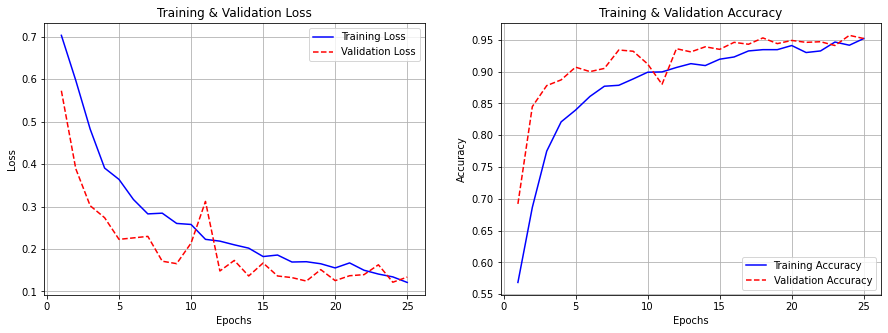

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_accuracy'], 'r--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()

plt.show()

> ## 5) Model Evaluate

* test_generator

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


* Loss & Accuracy

In [16]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 4s 74ms/step - loss: 0.1482 - accuracy: 0.9530
Loss = 0.14820
Accuracy = 0.95300


# 
# 
# 
# The End
# 
# 
# 